In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import sklearn.datasets as skldata
n = 1000
m = 2000


X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3, random_state=42)
C = 1

In [3]:
import cvxpy as cvx
x = cvx.Variable(n)

obj = cvx.Minimize(cvx.norm(x, 2)**2 / 2 + C * cvx.sum(cvx.logistic(cvx.multiply(-y, X @ x))) / m)
prob = cvx.Problem(obj)
prob.solve(verbose=True)
print("Optimal value =", prob.value)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 23 08:35:28 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 23 08:35:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 23 08:35:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 23 08:35:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 23 08:35:28 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 23 08:35:28 PM: Compiling problem (target solver=CLARABEL)

In [4]:
@jax.jit
def f(w):
    return jnp.linalg.norm(w)**2 / 2 +  C * jnp.mean(jnp.logaddexp(jnp.zeros(X.shape[0]), -y * (X @ w)))

grad_f = jax.jit(jax.grad(f))
hess_f = jax.jit(jax.hessian(f))
x0 = jnp.ones(n)
%timeit grad_f(x0).block_until_ready()
%timeit hess_f(x0).block_until_ready()

1.18 ms ± 425 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
107 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def newton(grad, hess, x0, alpha, num_iter, tol):
  conv = [x0.copy()]
  x = x0.copy()
  for iter_idx in range(num_iter):
    g = grad(x)
    if jnp.linalg.norm(g) < tol:
      break
    H = hess(x)
    h = jnp.linalg.solve(H, -g)
    alpha = 1
    while True:
      x_next = x + alpha * h
      if f(x_next) < f(x):
        print(alpha)
        x = x_next
        break
      else:
        alpha = 0.5 * alpha
        if alpha < 1e-16:
          break
    if alpha < 1e-16:
      break
    conv.append(x.copy())
  return x, conv

In [6]:
H = hess_f(x0)
g = grad_f(x0)
%timeit jnp.linalg.solve(H, -g)

The slowest run took 5.85 times longer than the fastest. This could mean that an intermediate result is being cached.
52.3 μs ± 32.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
import time
st = time.time()
x_n, conv_n = newton(grad_f, hess_f, x0, 1., 20, 1e-7)
print(time.time() - st)

1
0.5
0.25
0.125
1
0.25
0.25
1
1
1
1
1
1
3.347858190536499


In [8]:
[f(x) - prob.value for x in conv_n], [jnp.linalg.norm(grad_f(x)) for x in conv_n]

([Array(554.2388368, dtype=float64),
  Array(180.61705903, dtype=float64),
  Array(156.57186551, dtype=float64),
  Array(20.80299338, dtype=float64),
  Array(8.15189014, dtype=float64),
  Array(5.47642493, dtype=float64),
  Array(0.97865706, dtype=float64),
  Array(0.15807824, dtype=float64),
  Array(0.09416734, dtype=float64),
  Array(0.01431113, dtype=float64),
  Array(0.00088557, dtype=float64),
  Array(8.22749944e-06, dtype=float64),
  Array(1.2610743e-09, dtype=float64),
  Array(-1.26010313e-14, dtype=float64)],
 [Array(37.29585929, dtype=float64),
  Array(27.86140098, dtype=float64),
  Array(28.52778629, dtype=float64),
  Array(15.92844243, dtype=float64),
  Array(4.52162863, dtype=float64),
  Array(11.23824091, dtype=float64),
  Array(13.26424188, dtype=float64),
  Array(1.45362198, dtype=float64),
  Array(2.30505028, dtype=float64),
  Array(0.59178147, dtype=float64),
  Array(0.19945032, dtype=float64),
  Array(0.02067353, dtype=float64),
  Array(0.00028514, dtype=float64),
  A

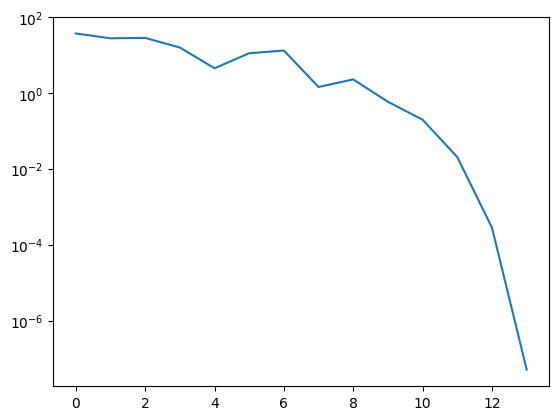

In [9]:
plt.semilogy([jnp.linalg.norm(grad_f(x)) for x in conv_n])

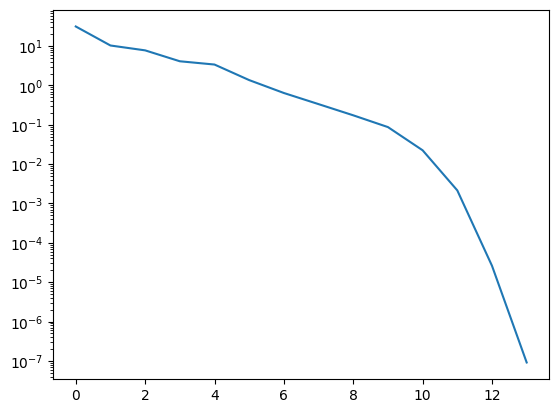

In [10]:
plt.semilogy([jnp.linalg.norm(x_j - x.value) for x_j in conv_n])

In [11]:
import scipy.optimize as scopt
bfgs_conv = []
st = time.time()
res_bfgs = scopt.minimize(f, x0, method="BFGS", jac=grad_f,
                          callback=lambda x: bfgs_conv.append(x.copy()))
print(time.time() - st)

2.2477381229400635


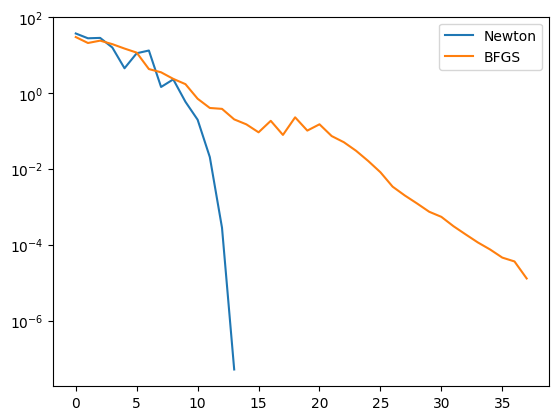

In [ ]:
plt.semilogy([jnp.linalg.norm(grad_f(x)) for x in conv_n], label="Newton")
plt.semilogy([jnp.linalg.norm(grad_f(x)) for x in bfgs_conv], label="BFGS")
plt.legend()

In [ ]:
lbfgs_conv = []
st = time.time()
res_lbfgs = scopt.minimize(f, x0, method="L-BFGS-B", jac=grad_f,
                          callback=lambda x: lbfgs_conv.append(x.copy()))
print(time.time() - st)

0.6862928867340088


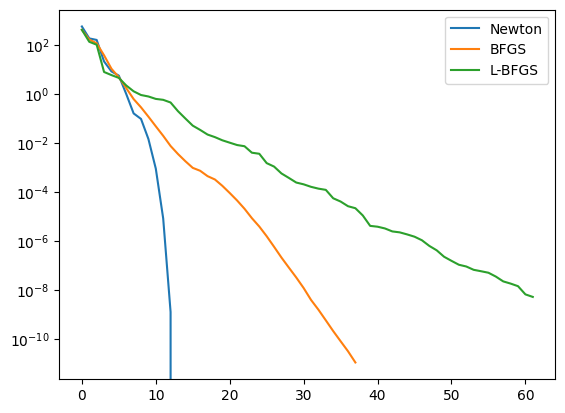

In [ ]:
plt.semilogy([f(x) - prob.value for x in conv_n], label="Newton")
plt.semilogy([f(x) - prob.value for x in bfgs_conv], label="BFGS")
plt.semilogy([f(x) - prob.value for x in lbfgs_conv], label="L-BFGS")
plt.legend()